In [1]:
# !pip install opencv-python

In [2]:
# !pip install torchvision

In [3]:
import torch
import numpy as np
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import cv2
import matplotlib.pyplot as plt
from deepmag import dataset, viz, model, train

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

/home/uva_ki_rhijnwiegman/motion-magnification-master/deepmag/train.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [4]:
torch.cuda.get_device_name()

'NVIDIA A40'

In [13]:
m = torch.load('data/models/20191202-b10-r0.1-lr0.0001-00.pt').to(device)
m

/home/uva_ki_rhijnwiegman/.local/lib/python3.10/site-packages/torch/serialization.py:1079: UserWarning: Couldn't retrieve source code for container of type MagNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/uva_ki_rhijnwiegman/.local/lib/python3.10/site-packages/torch/serialization.py:1079: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/uva_ki_rhijnwiegman/.local/lib/python3.10/site-packages/torch/serialization.py:1079: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "
/home/uva_ki_rhijnwiegman/.local/lib/python3.10/site-packages/torch/serialization.py:1079: UserWarning: Couldn't retrieve source code for container of t

MagNet(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ReflectionPad2d((3, 3, 3, 3))
      (1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1))
      (2): ReLU()
      (3): ReflectionPad2d((1, 1, 1, 1))
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (5): ReLU()
    )
    (res): Sequential(
      (0): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (2): ReLU()
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        )
      )
      (1): ResidualBlock(
        (block): Sequential(
          (0): ReflectionPad2d((1, 1, 1, 1))
          (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
          (2): ReLU()
          (3): ReflectionPad2d((1, 1, 1, 1))
          (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        )
      )
      (2): ResidualBlock(
        (block): Seque

(-0.5, 959.5, 543.5, -0.5)

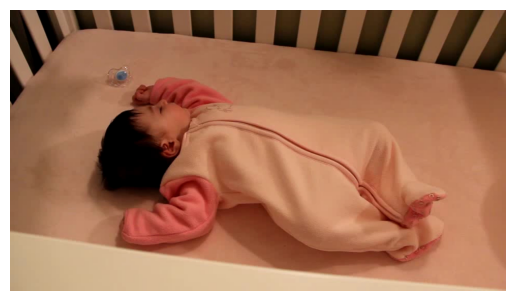

In [6]:
# vid = cv2.VideoCapture('data/examples/baby.mp4')
# vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
# plt.imshow(vid.read()[1][...,::-1])

frame = cv2.imread('data/examples/baby_frames/baby000.jpg')[...,::-1]
plt.imshow(frame)
plt.axis('off')

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])

frame_a = cv2.imread('data/examples/baby_frames/baby000.jpg')[...,::-1]
frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
frame_b = cv2.imread('data/examples/baby_frames/baby001.jpg')[...,::-1]
frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)

amplification = 100
amp_f_tensor = torch.tensor(
            [[float(amplification)]], dtype=torch.float, device=device)

In [8]:
%%timeit
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

The slowest run took 6.84 times longer than the fastest. This could mean that an intermediate result is being cached.
23.1 ms ± 15.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
pred, _, _ = m.forward(
    frame_a.to(device),
    frame_b.to(device),
    amp_f_tensor.reshape(1, 1).to(device))

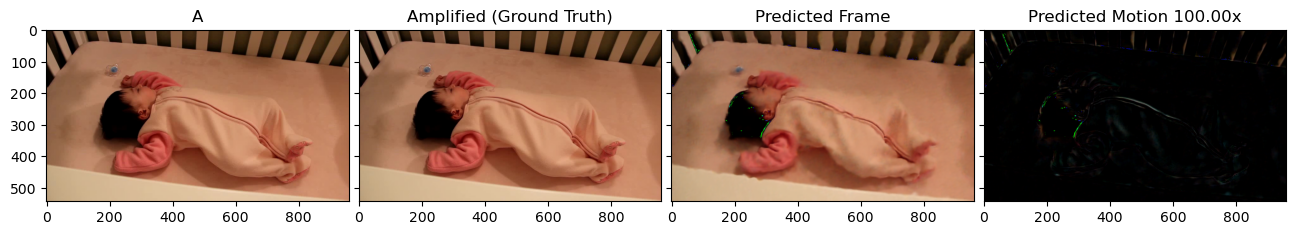

In [10]:
viz.show_pred(frame_a[0],
          frame_b[0],
          amp_f_tensor,
          pred[0].cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 959.5, 543.5, -0.5)

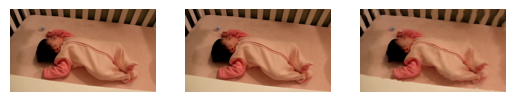

In [11]:
plt.subplot(1,3,1)
plt.imshow(frame_a[0].permute(1,2,0).cpu())
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(frame_b[0].permute(1,2,0).cpu())
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(pred[0].permute(1,2,0).cpu().detach().numpy())
plt.axis('off')

In [12]:
# for i in range(10):
#     print('{:03d}'.format(i))

In [27]:
# save predicted output images from the baby video from each 2-frame pair
for i in range(300):
    frame_a = cv2.imread('data/examples/baby_frames/baby' + '{:03d}'.format(i) + '.jpg')[...,::-1]
    frame_a = torch.unsqueeze(transform(to_pil_image(frame_a)).to(device), 0)
    frame_b = cv2.imread('data/examples/baby_frames/baby' + '{:03d}'.format(i+1) + '.jpg')[...,::-1]
    frame_b = torch.unsqueeze(transform(to_pil_image(frame_b)).to(device), 0)
    pred, _, _ = m.forward(
        frame_a.to(device),
        frame_b.to(device),
        amp_f_tensor.reshape(1, 1).to(device))
    pred = pred[0].permute(1,2,0).detach().cpu().numpy()[...,::-1]
    file_path = 'data/examples/baby_frames_output/baby' + '{:03d}'.format(i) + '_output.jpg'
    cv2.imwrite(file_path, 255*pred)